In [1]:
import time
import hydra
from hydra.utils import to_absolute_path
import torch
import sys
import os
import torch.nn as nn

import argparse

from dgl.dataloading import GraphDataLoader
import dgl
from omegaconf import DictConfig

from torch.cuda.amp import GradScaler, autocast
from torch.nn.parallel import DistributedDataParallel

#project_path = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', ''))
#sys.path.append(project_path)
project_path = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
sys.path.append(project_path)

from python.create_dgl_dataset import TelemacDataset
from modulus.distributed.manager import DistributedManager
from modulus.launch.logging import (
    PythonLogger,
    RankZeroLoggingWrapper,
    initialize_wandb,
)
from modulus.launch.utils import load_checkpoint, save_checkpoint
from python.CustomMeshGraphNet import MeshGraphNet

In [2]:
from hydra.utils import to_absolute_path

In [3]:
import numpy as np

In [4]:
def collate_fn(batch):
    # batch is a list of sequences
    # Each sequence is a list of graphs (of length sequence_length)
    # We want to batch the graphs at each time step across sequences

    sequence_length = len(batch[0])  # Assuming all sequences have the same length

    batched_graphs = []
    for t in range(sequence_length):
        graphs_at_t = [sequence[t] for sequence in batch]
        batched_graph = dgl.batch(graphs_at_t)
        batched_graphs.append(batched_graph)

    return batched_graphs

class TestRollout:
    def __init__(self, cfg: DictConfig, logger: PythonLogger):
        self.sequence_length = cfg.sequence_length  # Use sequence_length from config
        self.overlap = cfg.overlap 
        # Set device
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        logger.info(f"Using {self.device} device")
        
        # Instantiate dataset
        self.dataset = TelemacDataset(
            name="telemac_test",
            data_dir=to_absolute_path(cfg.data_dir),
            dynamic_data_files=[to_absolute_path(path) for path in cfg.dynamic_dir],
            split="test",
            ckpt_path=cfg.ckpt_path,
            normalize=True,
            sequence_length=self.sequence_length,
            overlap=self.sequence_length
        )
        # Instantiate dataloader
        self.dataloader = GraphDataLoader(
            self.dataset,
            batch_size=1,  
            shuffle=False,
            drop_last=False,
            collate_fn=collate_fn,  # Use custom collate_fn if defined
        )
        print(f"DataLoader Length: {len(self.dataloader)}")

        # Instantiate the model
        self.model = MeshGraphNet(
            cfg.num_input_features,
            cfg.num_edge_features,
            cfg.num_output_features,
            processor_size=cfg.mp_layers,
            hidden_dim_processor=64,
            hidden_dim_node_encoder=64,
            hidden_dim_edge_encoder=64,
            hidden_dim_node_decoder=64,
            do_concat_trick=cfg.do_concat_trick,
            num_processor_checkpoint_segments=cfg.num_processor_checkpoint_segments,
        )
        if cfg.jit:
            self.model = torch.jit.script(self.model).to(self.device)
        else:
            self.model = self.model.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Load checkpoint
        load_checkpoint(
            to_absolute_path(cfg.ckpt_path),
            models=self.model,
            device=self.device,
            epoch=2000,
        )
        self.model = self.model.to(self.device)
        
        # Get the stats needed to denormalize and normalize
        node_stats = self.dataset.node_stats
        self.h_u_v_i_0_mean = np.array([
            node_stats['h'].item(),
            node_stats['u'].item(),
            node_stats['v'].item()
        ])
        self.h_u_v_i_0_std = np.array([
            node_stats['h_std'].item(),
            node_stats['u_std'].item(),
            node_stats['v_std'].item()
        ])

        self.delta_h_u_v_i_diff_mean = np.array([
            node_stats['delta_h'].item(),
            node_stats['delta_u'].item(),
            node_stats['delta_v'].item()
        ])
        self.delta_h_u_v_i_diff_std = np.array([
            node_stats['delta_h_std'].item(),
            node_stats['delta_u_std'].item(),
            node_stats['delta_v_std'].item()
        ])
        
        # Define feature indices
        self.dynamic_feature_start = 6  # Adjust based on your actual feature indices
        self.dynamic_feature_end = 9  # Adjust based on your actual feature indices
        
    def predict(self, graph):
        """
        Predicts the next time step given the input graph.
        Denormalizes input features and predictions.
        Returns the denormalized predicted values.
        """
        with torch.no_grad():
            pred = self.model(
                graph.ndata['x'].to(self.device),
                graph.edata['x'].to(self.device),
                graph.to(self.device)
            ).cpu().numpy()
        
        # Denormalize data
        h_u_v_i_0 = self._denormalize_data(
            graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
            self.h_u_v_i_0_mean,
            self.h_u_v_i_0_std
        )

        # Compute predicted h, u, v at next time step
        h_u_v_i_1_pred = self._denormalize_data(
            pred,
            self.delta_h_u_v_i_diff_mean,
            self.delta_h_u_v_i_diff_std
        ) + h_u_v_i_0
                
        return h_u_v_i_1_pred, h_u_v_i_0
        
    def maj_mask(self, pred, next_step):
        """
        Updates predictions by applying boundary conditions from the next step.
        pred and next_step are normalized.
        """
        next_step_np = next_step.numpy()
        # Identify nodes with specific boundary conditions
        self.q_mask = (next_step_np[:, 0:4] == [0, 0, 1, 0]).all(axis=1)
        self.h_mask = (next_step_np[:, 0:4] == [0, 1, 0, 0]).all(axis=1)
        result = np.empty_like(next_step_np)
        
        # Copy static features from next_step
        result[:, 0:6] = next_step_np[:, 0:6]
        
        # Use predictions for dynamic features
        result[:, 6:9] = pred
        
        # Apply boundary conditions
        result[self.q_mask, 6:9] = next_step_np[self.q_mask, 6:9]
        result[self.h_mask, 6:7] = next_step_np[self.h_mask, 6:7]
        return result 
    
    def predict_unroll(self, unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        for sequence in self.dataloader:
            # sequence is now a list of graphs
            sequence_length = len(sequence)
            if sequence_length < unroll_steps + 1:
                continue  # Skip sequences that are too short

            graph = sequence[0].clone()  # Start from the first graph in the sequence
            h_u_v_i_0 = None  # To store initial input at time t=0
            for i in range(unroll_steps):
                next_graph = sequence[i + 1]
                h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

                if i == 0:
                    origin.append(h_u_v_i_0)

                #noise_filter = h_u_v_i_1_pred[:, 0] < 5e-3
                #h_u_v_i_1_pred[noise_filter, :] = 0.0

                # Normalize the prediction to transfer to the next graph
                h_u_v_i_1_pred_norm = self._normalize_data(
                    h_u_v_i_1_pred,
                    self.h_u_v_i_0_mean,
                    self.h_u_v_i_0_std
                )

                # Apply boundary conditions
                next_step_result = self.maj_mask(
                    h_u_v_i_1_pred_norm,
                    next_graph.ndata['x']
                )

                # Update the graph's node features for the next prediction
                graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))

        return predict, groundtruth, origin
    
    def predict_unroll_one_start(self,unroll_steps=1):
        predict = []
        groundtruth = []
        origin = []
        sequence = next(iter(self.dataloader))
        graph = sequence[0].clone()  # Start from the first graph in the sequence
        h_u_v_i_0 = None  # To store initial input at time t=0
        for i in range(unroll_steps):
            next_graph = sequence[i + 1]
            h_u_v_i_1_pred, h_u_v_i_0 = self.predict(graph)

            if i == 0:
                origin.append(h_u_v_i_0)



            # Normalize the prediction to transfer to the next graph
            h_u_v_i_1_pred_norm = self._normalize_data(
                h_u_v_i_1_pred,
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
                )

            # Apply boundary conditions
            next_step_result = self.maj_mask(
                h_u_v_i_1_pred_norm,
                next_graph.ndata['x']
            )

            # Update the graph's node features for the next prediction
            graph.ndata['x'] = torch.tensor(next_step_result, dtype=torch.float32)

            predict.append(h_u_v_i_1_pred)
            # Denormalize ground truth from next_graph
            groundtruth.append(self._denormalize_data(
                next_graph.ndata['x'][:, self.dynamic_feature_start:self.dynamic_feature_end].numpy(),
                self.h_u_v_i_0_mean,
                self.h_u_v_i_0_std
            ))

        return predict, groundtruth, origin

    def _denormalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return tensor * std + mean 
    
    def _normalize_data(self, tensor, mean, std):
        assert tensor.shape[1] == mean.shape[0]
        return (tensor - mean) / std
    
    def get_raw_data(self, idx):
        self.pred_i = [var[:, idx] for var in self.pred]
        self.exact_i = [var[:, idx] for var in self.exact]
        return self.graphs, self.faces, self.pred_i, self.exact_i



In [14]:
import hydra
from hydra import initialize, compose
from omegaconf import DictConfig, OmegaConf

import time 

# Initialize Hydra and set the configuration directory
with initialize(config_path="../bin/conf"):
    logger = PythonLogger("main")  # General python logger
    logger.file_logging()
    # Compose the configuration using the config name
    cfg = compose(config_name="Config1Group3Shortx1MultiTest")
    
    # Now call the training function with the composed config
    test = TestRollout(cfg,logger)
    t1= time.time()
    predict,groundtruth,origin = test.predict_unroll_one_start(unroll_steps=30)
    wall_time = time.time()-t1
    print(wall_time)
    print(wall_time/30)

/tmp/ipykernel_445612/3590853127.py:8: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../bin/conf"):
[15:45:13 - main - INFO] Using cuda device


Loading normalization statistics...
{'h': tensor([0.9846], dtype=torch.float64), 'u': tensor([0.0038], dtype=torch.float64), 'v': tensor([4.1178e-05], dtype=torch.float64), 'strickler': tensor([20.6628], dtype=torch.float64), 'z': tensor([17.5927], dtype=torch.float64), 'delta_h': tensor([0.0010], dtype=torch.float64), 'delta_u': tensor([-0.0005], dtype=torch.float64), 'delta_v': tensor([-7.5052e-05], dtype=torch.float64), 'h_std': tensor([0.1232], dtype=torch.float64), 'u_std': tensor([0.0619], dtype=torch.float64), 'v_std': tensor([0.0064], dtype=torch.float64), 'strickler_std': tensor([11.6977], dtype=torch.float64), 'z_std': tensor([13.9988], dtype=torch.float64), 'delta_h_std': tensor([0.0840], dtype=torch.float64), 'delta_u_std': tensor([0.0497], dtype=torch.float64), 'delta_v_std': tensor([0.0332], dtype=torch.float64)}
{'xrel': tensor([0.], dtype=torch.float64), 'yrel': tensor([0.], dtype=torch.float64), 'norm': tensor([24.7882], dtype=torch.float64), 'xrel_std': tensor([33.547

[15:45:15 - checkpoint - INFO] Loaded model state dictionary /work/m24046/m24046mrcr/new_tests_Group3/config1_short/MeshGraphNet.0.2000.mdlus to device cuda
[15:45:15 - checkpoint - INFO] Loaded checkpoint file /work/m24046/m24046mrcr/new_tests_Group3/config1_short/checkpoint.0.2000.pt to device cuda


DataLoader Length: 1
11.32702112197876
0.3775673707326253


In [6]:
from python.python_code.data_manip.extraction.telemac_file import TelemacFile
from python.create_dgl_dataset import add_mesh_info
from matplotlib.tri import Triangulation

mesh_list = ['/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf']
res_mesh = TelemacFile(mesh_list[0])
X,triangles = add_mesh_info(res_mesh)

In [7]:
res_mesh_fine = TelemacFile('/work/m24046/m24046mrcr/results_data_30min/maillage_3.slf')
X_fine,triangles_fine = add_mesh_info(res_mesh_fine)
triangulation = Triangulation(X_fine[:, 0], X_fine[:, 1], triangles_fine)


In [8]:
print(len(predict))
print(len(groundtruth))
print(len(origin))

30
30
1


In [9]:
from scipy.interpolate import griddata


In [10]:
predict_h = [arr[:,0] for arr in predict]
groundtruth_h = [arr[:,0] for arr in groundtruth]
origin_h = [arr[:,0] for arr in origin]

projected_predi = []

if X_fine.shape != X.shape :
    for pred in predict_h : 
        projected = griddata((X[:, 0], X[:, 1]), pred, (X_fine[:, 0], X_fine[:, 1]), method='linear')
        projected_predi.append(np.nan_to_num(projected,0.0))
else : 
    projected_predi=predict_h
    
max_h =  max(np.max([np.max(arr) for arr in predict_h]),np.max([np.max(arr) for arr in groundtruth_h]))

/tmp/ipykernel_445612/3327987768.py:23: UserWarning: The following kwargs were not used by contour: 'rasterized'
  contour = ax.tricontourf(


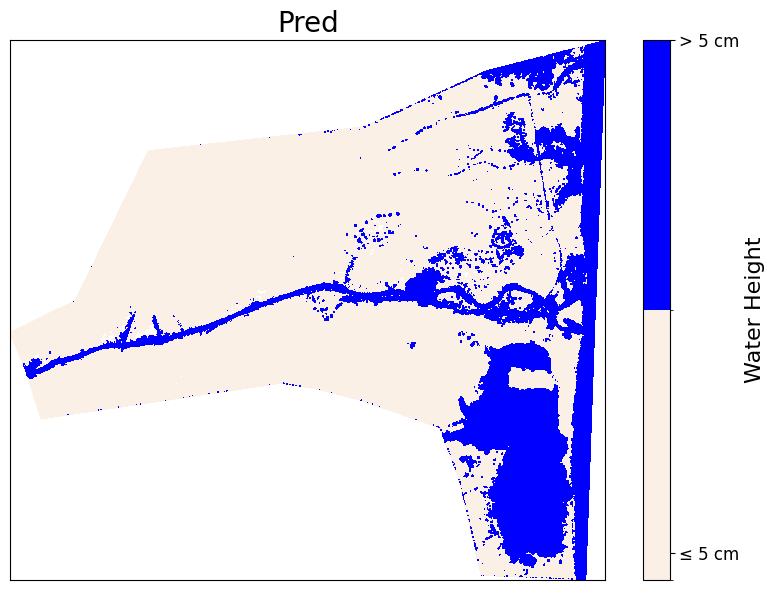

In [11]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.tri as tri

# Supposons que data_pred, data_groundtruth, ori, et triangulation_fine sont déjà définis

# Définir les couleurs pour la colormap binaire
colors = ['linen', 'blue']
cmap = ListedColormap(colors)

bounds_a_def = 0.05
# Définir les limites pour la normalisation
bounds = [0.0, bounds_a_def, max_h]
norm = BoundaryNorm(bounds, cmap.N)

# Fonction pour tracer et enregistrer une figure
def plot_and_save(data, title, filename, fontsize_titles=20, fontsize_labels=16, fontsize_ticks=12):
    # Créer une nouvelle figure
    fig, ax = plt.subplots(figsize=(8, 6))  # Taille de la figure ajustable
    
    # Tracer les données
    contour = ax.tricontourf(
        triangulation, data, levels=bounds, cmap=cmap, norm=norm, rasterized=True
    )
    
    # Définir le titre en anglais
    ax.set_title(title, fontsize=fontsize_titles)
    
    # Supprimer les ticks et labels si nécessaire
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Ajouter une barre de couleur
    cbar = fig.colorbar(contour, ax=ax, ticks=[0.005, bounds[2]-0.005])
    cbar.ax.set_yticklabels(['≤ 5 cm', '> 5 cm'])
    cbar.ax.tick_params(labelsize=fontsize_ticks)
    cbar.set_label('Water Height', fontsize=fontsize_labels)
    
    # Ajuster la mise en page pour minimiser les espaces inutiles
    plt.tight_layout()
    
    # Enregistrer la figure avec une résolution réduite
    #plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    # Fermer la figure pour libérer de la mémoire
    plt.close(fig)
    
pdt = 20
plot_and_save(projected_predi[pdt],'Pred','test')


In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec

# Définir les couleurs pour la colormap binaire
colors = ['linen', 'blue']
cmap = ListedColormap(colors)

# Définir les limites pour la normalisation
bounds_a_def = 0.05
bounds = [0.0, bounds_a_def, 10.0]
norm = BoundaryNorm(bounds, cmap.N)

# Fonction pour tracer plusieurs pas de temps côte à côte
def plot_timesteps(data_list, triangulation, filename, timesteps, 
                   fontsize_labels=16, fontsize_ticks=12, dpi=300, save=False):
    n_plots = len(data_list)  # Nombre de pas de temps
    
    # Créer une grille pour ajuster la position de la barre de couleur
    fig = plt.figure(figsize=(4 * n_plots, 4))
    gs = GridSpec(1, n_plots + 1, width_ratios=[1] * n_plots + [0.05], wspace=0.1)
    
    axs = [fig.add_subplot(gs[0, i]) for i in range(n_plots)]
    
    # Tracer chaque pas de temps
    for i, data in enumerate(data_list):
        contour = axs[i].tricontourf(
            triangulation, data, levels=bounds, cmap=cmap, norm=norm, rasterized=True
        )
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_aspect('equal')  # Pour garder les proportions
    
    # Ajouter une seule barre de couleur
    cbar_ax = fig.add_subplot(gs[0, -1])  # Dernière colonne pour la barre de couleur
    cbar = fig.colorbar(contour, cax=cbar_ax)
    cbar.set_label('Water Height', fontsize=fontsize_labels)
    cbar.ax.tick_params(labelsize=fontsize_ticks)
    
    # Sauvegarder ou afficher
    if save:
        plt.savefig(filename, dpi=dpi, format='pdf', bbox_inches='tight')
    else:
        plt.show()
    
    # Libérer la mémoire
    plt.close(fig)



# Exemple d'utilisation
timesteps = [2,6,10,14,18]  # Les pas de temps à tracer
data_list = [groundtruth_h[t] for t in timesteps]

plot_timesteps(data_list, triangulation, './datas/final_plotGD.pdf', timesteps, save=False)


/tmp/ipykernel_445612/1824362563.py:27: UserWarning: The following kwargs were not used by contour: 'rasterized'
  contour = axs[i].tricontourf(
